<a href="https://colab.research.google.com/github/tohver/Natural_Language_Processing/blob/master/AGNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flair
!pip install sentence-transformers
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
from sklearn.model_selection import train_test_split
from pathlib import Path
import seaborn as sns
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus
from flair.data import Corpus
from flair.embeddings import StackedEmbeddings, FlairEmbeddings, WordEmbeddings, DocumentRNNEmbeddings, DocumentLSTMEmbeddings, TransformerWordEmbeddings, SentenceTransformerDocumentEmbeddings
from flair.data import Sentence
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from torch.optim.adam import Adam

path = Path('/content/drive/MyDrive/Colab Notebooks/data/AG_News')

In [5]:
news = pd.read_csv(path/'train_raw.csv', header = None)
news.head(2)

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...


In [7]:
for i in range(10):
  print(f'{news.iloc[i,1]}\n{news.iloc[i,2]}\n')
news['text'] = news[1] + ' ' + news[2]
news.columns = ['labels', 't1', 't2', 'text']
newsDf = news[['labels', 'text']]
newsDf.shape

Wall St. Bears Claw Back Into the Black (Reuters)
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Carlyle Looks Toward Commercial Aerospace (Reuters)
Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

Oil and Economy Cloud Stocks' Outlook (Reuters)
Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)
Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Oil prices soar to all-time record, posing new menace to US economy (AFP)
AFP - Tearaway world

(120000, 2)

In [9]:
newsDf.head(2)

,labels,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...


In [8]:
test = pd.read_csv(path/'test_raw.csv', header = None)
test['text'] = test[1] + ' ' + test[2]
test.columns = ['labels', 't1', 't2', 'text']
test = test[['labels', 'text']]
test.to_csv(path/'test.csv', header = None)

In [9]:
train, val = train_test_split(newsDf, test_size = .05, random_state = 0, stratify = newsDf['labels'])
train.to_csv(path/'train.csv', header = None)
val.to_csv(path/'dev.csv', header = None)

In [10]:
print(f'train set: {train.labels.value_counts()}\n')
print(f'test set: {test.labels.value_counts()}\n')
print(f'val set: {val.labels.value_counts()}\n')

train set: 4    28500
3    28500
2    28500
1    28500
Name: labels, dtype: int64

test set: 3    1900
2    1900
1    1900
4    1900
Name: labels, dtype: int64

val set: 3    1500
2    1500
1    1500
4    1500
Name: labels, dtype: int64



In [11]:
val.head()

,labels,text
100830,3,P2P Music Upstart Signs On the Big Boys A new ...
65783,1,US must wait to prosecute Muslim cleric LONDON...
4250,4,OSDL introduces improved Linux kernel developm...
70666,3,"Bangalore Thrives, Chokes on Outsourcing BANG..."
60099,4,"With Help, Sea Turtles Rally to Escape Oblivio..."


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


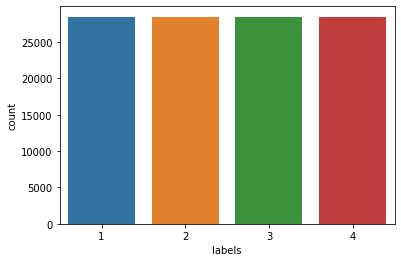

In [14]:
sns.countplot(train['labels'])

In [13]:
columnNameMap = {1 : 'label_topic', 2 : 'text'}
corpus: Corpus = CSVClassificationCorpus(path, column_name_map = columnNameMap)
label_dict = corpus.make_label_dictionary()

2021-02-18 23:28:26,202 Reading data from /content/drive/MyDrive/Colab Notebooks/data/AG_News
2021-02-18 23:28:26,203 Train: /content/drive/MyDrive/Colab Notebooks/data/AG_News/train.csv
2021-02-18 23:28:26,203 Dev: /content/drive/MyDrive/Colab Notebooks/data/AG_News/dev.csv
2021-02-18 23:28:26,207 Test: /content/drive/MyDrive/Colab Notebooks/data/AG_News/test.csv
2021-02-18 23:28:26,825 Computing label dictionary. Progress:


100%|██████████| 121600/121600 [02:10<00:00, 929.88it/s]

2021-02-18 23:30:37,739 [b'2', b'4', b'3', b'1']


In [14]:
document_transformer_embeddings = SentenceTransformerDocumentEmbeddings('bert-base-nli-mean-tokens')
classifier = TextClassifier(document_transformer_embeddings, label_dictionary=label_dict)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

100%|██████████| 405M/405M [00:14<00:00, 28.0MB/s]


In [15]:
trainer.train(path/'models/', learning_rate=3e-5, max_epochs = 10, patience=2, checkpoint = True, mini_batch_size = 16, mini_batch_chunk_size = 4)

2021-02-18 23:31:14,658 ----------------------------------------------------------------------------------------------------
2021-02-18 23:31:14,662 Model: "TextClassifier(
  (document_embeddings): SentenceTransformerDocumentEmbeddings(
    (model): SentenceTransformer(
      (0): Transformer(
        (auto_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_featu

{'dev_loss_history': [0.4104565382003784,
  0.36020976305007935,
  0.3414340019226074,
  0.330353319644928,
  0.32371780276298523,
  0.3182004690170288,
  0.3148873448371887,
  0.312004953622818,
  0.30851998925209045,
  0.30598127841949463],
 'dev_score_history': [0.8677,
  0.8813,
  0.8828,
  0.8857,
  0.8873,
  0.888,
  0.8887,
  0.8882,
  0.8913,
  0.89],
 'test_score': 0.8896,
 'train_loss_history': [0.6083388389680993,
  0.39383019639930705,
  0.36673819316515144,
  0.35406898864816155,
  0.3328147403919056,
  0.3353817652792,
  0.322695233957842,
  0.3257736471523776,
  0.32150313759876187,
  0.3186222939234096]}

In [ ]:
!pip install flair
from flair.models import TextClassifier

In [ ]:
!pip install sentence-transformers

In [10]:
from flair.data import Sentence
from pathlib import Path
path = Path('/content/drive/MyDrive/Colab Notebooks/data/AG_News')
new_clf = TextClassifier.load(path / 'models/best-model.pt')
classes = {'1' : "World", '2' : "Sports", '3' : "Business", '4' : "Sci/Tech"}


In [8]:
phrase = "Mohamed Salah and Sadio Mane struck in the space of five minutes near the start of the second half in an away leg played in Budapest's Puskas Arena because of Covid-19 restrictions. It came after the Reds had fallen to three straight defeats in the Premier League - results that have led Klopp to concede defeat in their defence of the English top-flight title. But Tuesday's display was far more like the dominant side of last season, with their greater experience and quality ultimately telling against an error-prone German side."

In [12]:
sentence = Sentence(phrase)

In [13]:
new_clf.predict(sentence)

In [30]:
print(f'This text is belongs to the class {classes[str(sentence.labels[0])[0]]}')

This text is belongs to the class Sports
